### SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
import xgboost as XGB
from sklearn.ensemble import AdaBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Read data

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

train = df_train.copy()
test = df_test.copy()

# Data Exploration

In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train[['MSSubClass', 'LotArea', 'Street']]

,MSSubClass,LotArea,Street
0,60,8450,Pave
1,20,9600,Pave
2,60,11250,Pave
3,70,9550,Pave
4,60,14260,Pave
...,...,...,...
1455,60,7917,Pave
1456,20,13175,Pave
1457,70,9042,Pave
1458,20,9717,Pave


In [5]:
f'Orginal train dataset shape is {train.shape} and orginal test dataset shape is {test.shape}. One column more in train dataset is our target'

'Orginal train dataset shape is (1460, 81) and orginal test dataset shape is (1459, 80). One column more in train dataset is our target'

In [6]:
print('We have following data types in data frame: {}'.format(train.dtypes.unique()))

We have following data types in data frame: [dtype('int64') dtype('O') dtype('float64')]


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

10 columns with the highes numbers of NaN values:
PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
dtype: float64



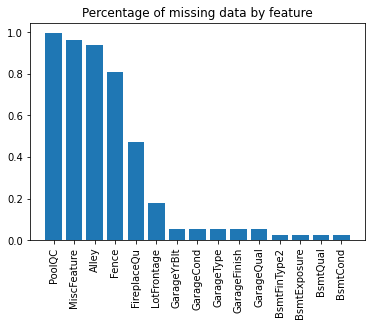

In [8]:
percentage_of_missing_values = (pd.isna(train).sum().sort_values(ascending=False)/len(train))[:15]
plt.bar(percentage_of_missing_values.index,percentage_of_missing_values)
plt.title('Percentage of missing data by feature')
x = [x for x in range(len(percentage_of_missing_values))]
plt.xticks(x, percentage_of_missing_values.index, rotation='vertical')
print('10 columns with the highes numbers of NaN values:\n{}\n'.format(percentage_of_missing_values))

- In a lot of cases NaN values mean that something is inaccessible. In this cases I will replace this value with "None" or -1
- After checking all features description I notice that in dataset we have two types of categorical features: *nominal* and *ordinal*. The *nominal categorical features* (where we don't have an order) I will preprocess with **pd.get_dummies()** function. *The ordical categorical features* I will transform to values which associated with the order.

#### Target feature

    Orginal target

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

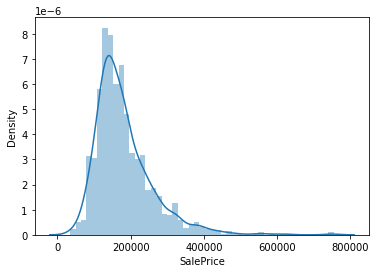

In [9]:
sns.distplot(train['SalePrice'],label = 'target')

In [10]:
train['SalePrice'].skew()

1.8828757597682129

The taget value has left skewness, but evaluation will be done between the logarithm of the predicted value and the logarithm of the observed sales price. Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

    After log-transformation

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

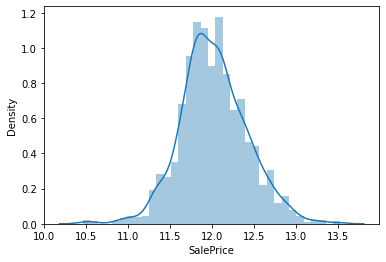

In [11]:
sns.distplot(np.log(train['SalePrice']),label = 'target')

In [12]:
np.log(train['SalePrice']).skew()

0.12133506220520406

With log/transformation we can correct a skew and the distribution is much closer to normal distribution

#### Features

Plot the best 10 correlations


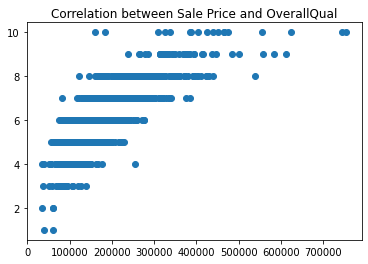

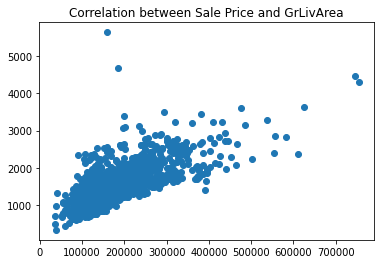

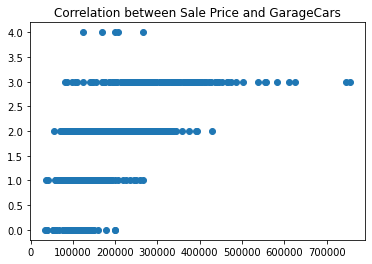

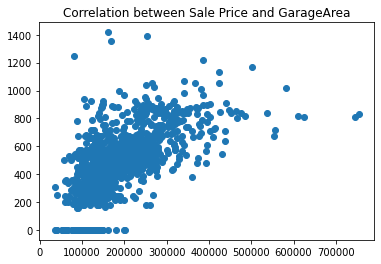

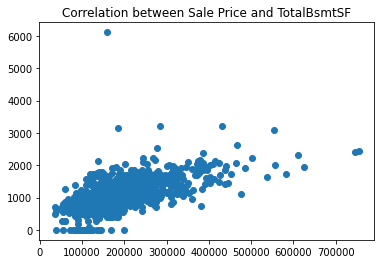

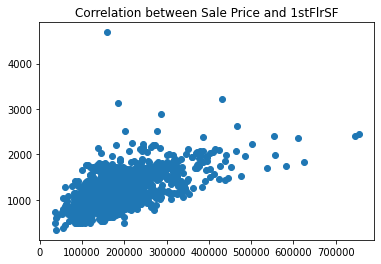

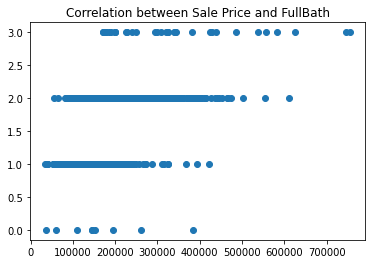

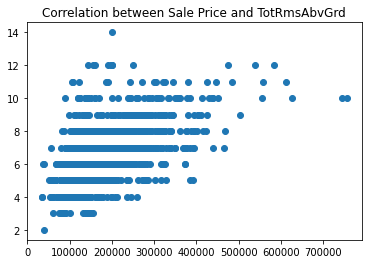

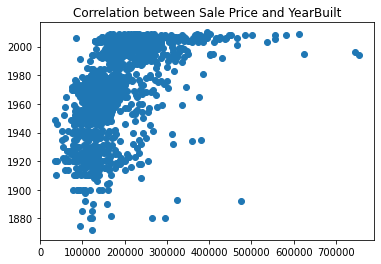

In [13]:
train.corr()['SalePrice'].sort_values(ascending=False)

print('Plot the best 10 correlations')

for col in train.corr()['SalePrice'].sort_values(ascending=False)[1:10].index:
    plt.figure()
    plt.scatter(train['SalePrice'],train[col])
    plt.title(f'Correlation between Sale Price and {col}')

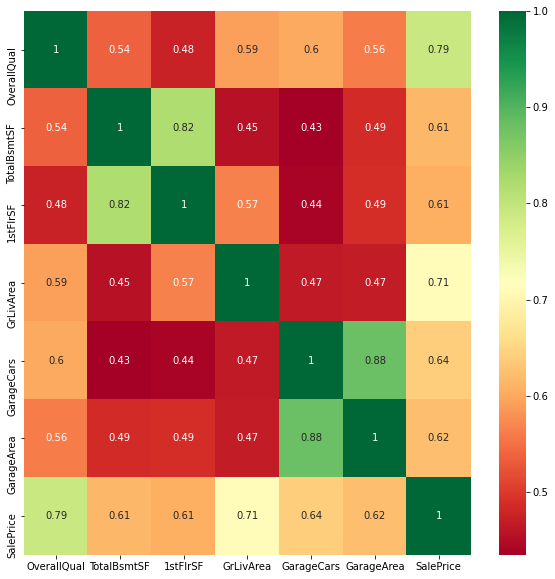

In [14]:
corr = train.corr()
high_corr = corr.index[abs(corr['SalePrice'])>0.6]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[high_corr].corr(),annot=True,cmap="RdYlGn")

# Data Preprocessing

In [15]:
class CleanData(BaseEstimator, TransformerMixin):
    """
    Drop columns 
    """
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_id = X.Id
        X = X.drop(self.columns_to_drop,axis=1)
        X = X.apply(lambda x: x.fillna('None') if x.dtype == object else x.fillna(-1))
        return X
    

class PrepareSkewData(BaseEstimator, TransformerMixin):
    """
    Unskew skwed data columns.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        skew_features = X.skew().sort_values()
        high_skew = skew_features[abs(skew_features)>0.5]
        for feature in high_skew.index:
            c = 0.0000001
            X[feature].apply(lambda x: np.log1p(c + x))
        return X
    

class EncodeLabel(BaseEstimator, TransformerMixin):
    """
     
    """
        
    cat_to_num = {'PoolQC':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0},
                  'ExterQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                  'ExterCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                  'BsmtQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
                  'BsmtCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
                  'BsmtExposure':{'Gd':4,'Av':3,'Mn':2,'No':1,'None':0},
                  'BsmtFinType1':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0},
                  'BsmtFinType2':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0},
                  'HeatingQC':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                  'CentralAir':{'N':0,'Y':1},
                  'KitchenQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
                  'FireplaceQu':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
                  'GarageQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},
                  'GarageCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}
                 }
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for col in X:
            mapping = self.cat_to_num.get(col)
            if mapping is not None:
                X[col] = X[col].map(mapping)
        return X
    

class AddFeatures(BaseEstimator, TransformerMixin):
    """
     
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['TotalBath'] = X['BsmtFullBath'] + X['BsmtHalfBath'] + X['FullBath'] + X['HalfBath']
        X['TotalGarage'] = X['GarageCars'] + X['GarageArea'] 
        X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']  
        #features ideas took from kaggle
        X["NEW_TOTALQUAL_index"] = X["OverallQual"] * X["GarageArea"] * X["GrLivArea"]
        X["NEW_Yr_sold"] = X["YrSold"] - X["YearBuilt"]
        X["NEW_Yr_sold_index"] = pd.qcut(X["NEW_Yr_sold"], q=5, labels=[5, 4, 3, 2, 1])
        X["NEW_Yr_sold_index"] = X["NEW_Yr_sold_index"].astype(int)
        X['NEW_TotalSF'] = (X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'])
        X['NEW_YrBltAndRemod'] = X['YearRemodAdd'] - X['YearBuilt']
        X["NEW_YrBltAndRemod"].min()
        X['NEW_Total_sqr_footage'] = (X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['1stFlrSF'] + X['2ndFlrSF'])
        X['NEW_Total_Bathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))
        X['NEW_Total_porch_sf'] = (X['OpenPorchSF'] + X['3SsnPorch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])
        X["NEW_AREA"] = X["GrLivArea"] + X["GarageArea"]
        X['TotalLot'] = X['LotFrontage'] + X['LotArea']
        X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
        X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
        X['TotalBath'] = X['FullBath'] + X['HalfBath']
        X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']
        X.loc[(X['MoSold'] >= 3) & (X['MoSold'] <= 5), 'New_MoSold_index'] = 'Spring'
        X.loc[(X['MoSold'] >= 6) & (X['MoSold'] <= 8), 'New_MoSold_index'] = 'Summer'
        X.loc[(X['MoSold'] >= 9) & (X['MoSold'] <= 11), 'New_MoSold_index'] = 'Autumn'
        X.loc[X["New_MoSold_index"].isnull(), "New_MoSold_index"] = "Winter"
        X["New_SqFtPerRoom"] = X["GrLivArea"] / (X["TotRmsAbvGrd"] + X["FullBath"] + X["HalfBath"] + X["KitchenAbvGr"])
        X["New_Garage_Area_ratio"] = (X["GarageArea"] / X["LotArea"]) * 100
        X["New_LotQuall"] = X["OverallQual"] * X["LotArea"]
        X["New_QuallYear"] = (X["YrSold"].max() - X["YearBuilt"]) * X["OverallQual"]
        X["New_Totall_Area"] = X["GarageArea"] + X["GrLivArea"]

        return X
    
class GetDummies(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.get_dummies(X)
        return X
    
def build_pipeline(
                   clean_data=True,
                   skew_data=True,
                   encode_label=True,
                   add_features=True,
                   get_dummies=True,
                   model=False,
                   columns_to_drop=['MiscFeature']
):
    pipeline_steps = []
    if clean_data:
        pipeline_steps.append(('clean_data', CleanData(columns_to_drop=columns_to_drop)))
    if skew_data:
        pipeline_steps.append(('skew_data', PrepareSkewData()))
    if encode_label:
        pipeline_steps.append(('encode_label', EncodeLabel()))
    if add_features:
        pipeline_steps.append(('add_features', AddFeatures()))
    if get_dummies:
        pipeline_steps.append(('get_gummies', GetDummies()))
    if model:
        pipeline_steps.append(('linear', LinearRegression()))
        
    return Pipeline(pipeline_steps)


def split_preprocess(train, test, processor):
    y_train = np.log(train['SalePrice'])
    train = train.drop('SalePrice',axis=1)

    pipeline_train = processor.fit_transform(train)
    train_id = pipeline_train['Id']
    train = pipeline_train.drop('Id',axis=1) 
    
    pipeline_test = processor.transform(test)# here fit_transform or 
    test_id = pipeline_test['Id']
    test = pipeline_test.drop('Id',axis=1)
    
    X_test = test[test.columns & train.columns]
    X_train = train[test.columns & train.columns]
    
    return X_train, y_train, X_test, test_id

def print_importances(model, feature_columns):
    df = pd.DataFrame(model.feature_importances_, feature_columns, columns=['importance'])
    return df.sort_values('importance', ascending=False)   

# Modelling

### Base model

Here we prepare the baseline training. This is a simple model without feature enginnering and advanced data preprocessing.

In [16]:
PREPROC_BASELINE_PARAMS = dict(clean_data=True,
    skew_data=False,
    encode_label=True,
    add_features=False,
    get_dummies=True,
    model=False,
    columns_to_drop=['MiscFeature']
)

SCORES = []


baseline_preprocessor = build_pipeline(**PREPROC_BASELINE_PARAMS)
X_train, y_train , X_test, test_id = split_preprocess(train, test, baseline_preprocessor)

model = RandomForestRegressor()
scores = cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=5)

SCORES.append({'model': model.__class__.__name__, 
               'score': np.mean(np.sqrt(-scores)),
               'feature_engineering': 'no'
              })
SCORES

[{'model': 'RandomForestRegressor',
  'score': 0.14249627251388883,
  'feature_engineering': 'no'}]

###  Training different models, improved data preparation and feature engineering

In [17]:

PREPROC_PARAMS = dict(
                   clean_data=True,
                   skew_data=True,
                   encode_label=True,
                   add_features=True,
                   get_dummies=True,
                   model=False
)

preprocessor = build_pipeline(**PREPROC_PARAMS)
X_train, y_train , X_test, test_id = split_preprocess(train, test, preprocessor)


rfr = RandomForestRegressor()

xgb = XGB.XGBRegressor()

el = ElasticNet(alpha=0.001, l1_ratio=0.5)

lm = LinearRegression()

voting_regressor = VotingRegressor(
                    estimators=[('rfr',rfr),('xgb',xgb),('el',el)])

MODELS = [lm, rfr,xgb,el,voting_regressor]


In [18]:
for model in MODELS:
    scores = cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
    SCORES.append({'model': model.__class__.__name__, 
                   'score': np.mean(np.sqrt(-scores)), 
                   'feature_engineering': 'yes'})

### Crossval Results

Clearly the XGBRegressor improves the results a bit in comparison to other models. The feature engineering doesn ot seem to have a huge impact on the scores.

In [19]:
pd.DataFrame(SCORES)

,model,score,feature_engineering
0,RandomForestRegressor,0.142496,no
1,LinearRegression,0.153985,yes
2,RandomForestRegressor,0.142053,yes
3,XGBRegressor,0.142106,yes
4,ElasticNet,0.130227,yes
5,VotingRegressor,0.124660,yes


### Generate predictions for test data to see if leaderboard scores are aligned with our CV.

In [21]:
for i, model in enumerate(MODELS):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    submission = pd.read_csv('submission/first_submission.csv')
    submission.Id = test_id
    submission.SalePrice = np.exp(pred)
    submission.to_csv(f'submission/{i}_{model.__class__.__name__}_results.csv',index=False)

### Grid search of parameters

In order to squeeze one more from our models we can perform parameters search.

In [22]:
xgb = XGB.XGBRegressor()


params = {
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]
}

random_search = RandomizedSearchCV(xgb, 
                                   cv=2,
                                   n_jobs=-1,
                                   param_distributions=params,n_iter=100, 
                                   verbose=2, 
                                   scoring='neg_mean_squared_error')
random_search.fit(X_train,y_train)
print(random_search.best_params_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
{'subsample': 0.7, 'reg_lambda': 5.0, 'n_estimators': 100, 'min_child_weight': 3.0, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6}


### Building  a voting regressor with improved XGBRegressor

In [23]:

xgb = XGB.XGBRegressor(**random_search.best_params_)
voting_regressor_imp = VotingRegressor(
                    estimators=[('rfr',rfr),('xgb',xgb),('el',el)])

In [24]:
scores = cross_val_score(voting_regressor_imp,X_train,y_train,scoring='neg_mean_squared_error',cv=5)

In [25]:
SCORES.append({'score': np.mean(np.sqrt(-scores)), 'model': 'VotingRegressorGridsearched', 'feature_engineering': 'yes'})

In [26]:
df = pd.DataFrame(SCORES)
df['leaderboard_score'] = ''
print(df.to_markdown())

|    | model                       |    score | feature_engineering   | leaderboard_score   |
|---:|:----------------------------|---------:|:----------------------|:--------------------|
|  0 | RandomForestRegressor       | 0.142496 | no                    |                     |
|  1 | LinearRegression            | 0.153985 | yes                   |                     |
|  2 | RandomForestRegressor       | 0.142053 | yes                   |                     |
|  3 | XGBRegressor                | 0.142106 | yes                   |                     |
|  4 | ElasticNet                  | 0.130227 | yes                   |                     |
|  5 | VotingRegressor             | 0.12466  | yes                   |                     |
|  6 | VotingRegressorGridsearched | 0.122292 | yes                   |                     |


In [27]:
voting_regressor_imp.fit(X_train, y_train)
pred = voting_regressor_imp.predict(X_test)
submission = pd.read_csv('submission/first_submission.csv')
submission.Id = test_id
submission.SalePrice = np.exp(pred)
submission.to_csv(f'submission/{model.__class__.__name__} gs_results.csv',index=False)

### Feature importance
To better understand whats going on with the models we can have a look at the feature importances. We can see that the features make sense to our problem.

In [28]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print_importances(rfr, X_train.columns)[:10]

,importance
NEW_TOTALQUAL_index,0.664743
NEW_Total_sqr_footage,0.056175
NEW_TotalSF,0.050766
OverallQual,0.015160
New_LotQuall,0.015033
YearRemodAdd,0.011798
BsmtQual,0.007628
TotalBsmtSF,0.007273
CentralAir,0.007229
OverallCond,0.007116
